# Experiments with ConvLSTM and LRCN models

In the following notebook there will be made experiments with different types of data. The data should be stored in a directory in this proyect 
called 'pruebas'. For the series of videos, they should be in 'pruebas/landmarksVids' for the gloveless tests, and 'pruebas/serie_prueba_guantes' for the tests 
made with a colored golves dataset. For any change, please change corresponding blocks. Models should be in 'models'

# Necesary Imports

In [1]:
from keras.models import load_model
from keras.utils import to_categorical

In [2]:
import numpy as np
import json
import pathlib
import random
import matplotlib.pyplot as plt
import cv2

# Auxilliary functions

In [3]:
subset_paths = {
  'train': pathlib.Path('./dataset/train'),
  'val': pathlib.Path('./dataset/val'),
  'test': pathlib.Path('./dataset/test'),
}

HEIGHT = 224
WIDTH = 224
N_FRAMES = 20
num_classes = 64

In [6]:
import math

def groupFrames(video_path, n_frames = N_FRAMES, frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  encoded_string = video_path.encode('latin-1')
  video_path = encoded_string.decode("utf-8")
  src = cv2.VideoCapture(video_path)  
  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)   
  if video_length < 80:
        frame_step = int(math.floor(frame_step/2))
  print(f'Video url: {video_path}, video_length:{video_length}')
  need_length = 1 + (n_frames - 1) * frame_step
  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)
  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  if ret: 
      frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
      frame = np.expand_dims(frame, axis=-1) 
      result.append(frame/255)
  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:   
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        frame = np.expand_dims(frame, axis=-1) 
        result.append(frame/255)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  cv2.destroyAllWindows()
  result = np.array(result)
  #print('SHAPE RESULT',result.shape)
  return result

In [7]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
    encoded_string = video_path.encode('latin-1')
    video_path = encoded_string.decode("utf-8")
    
    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f'Video url: {video_path}, video_length:{video_frames_count}')
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/N_FRAMES), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(N_FRAMES):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
            
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        frame = np.expand_dims(frame, axis=-1) 

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (WIDTH, HEIGHT))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [8]:
def find_id(labels,name):
   return list(filter(lambda x: x['name'] == name,labels))[0]

def get_files_and_class_names(path):
    video_paths = list(path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    f = open('./dataset.json')
    labels = json.load(f)
    classes = np.array(list(map(lambda x: int(find_id(labels,x)['id'])-1,classes)))
    encoded_labels = to_categorical(classes)
    #modificar entre groupFrames y frames_extraction
    videos = np.array([groupFrames(str(p)) for p in video_paths],dtype='float16')
    return videos, classes

# Preparing test data

In [27]:
x_test, y_test = get_files_and_class_names(subset_paths['test'])

Video url: dataset\test\Aceptar\050_001_002.avi, video_length:182.0
Video url: dataset\test\Aceptar\050_002_005.avi, video_length:152.0
Video url: dataset\test\Aceptar\050_003_004.avi, video_length:152.0
Video url: dataset\test\Aceptar\050_005_002.avi, video_length:152.0
Video url: dataset\test\Aceptar\050_006_002.avi, video_length:122.0
Video url: dataset\test\Aceptar\050_006_005.avi, video_length:122.0
Video url: dataset\test\Aceptar\050_007_003.avi, video_length:92.0
Video url: dataset\test\Aceptar\050_008_001.avi, video_length:122.0
Video url: dataset\test\Aceptar\050_008_004.avi, video_length:122.0
Video url: dataset\test\Aceptar\050_009_002.avi, video_length:152.0
Video url: dataset\test\Agua\022_001_004.avi, video_length:118.0
Video url: dataset\test\Agua\022_002_005.avi, video_length:118.0
Video url: dataset\test\Agua\022_003_002.avi, video_length:148.0
Video url: dataset\test\Agua\022_005_001.avi, video_length:118.0
Video url: dataset\test\Agua\022_005_005.avi, video_length:11

In [28]:
x_test.shape

(640, 20, 224, 224, 1)

## Modelo ConvLSTM

In [9]:
model = load_model('./models/modelConvLSTM')

In [ ]:
model.summary()

In [30]:
model_evaluation_history = model.evaluate(x_test,y_test)

20/20 [==============================] - 79s 4s/step - loss: 0.1163 - accuracy: 0.9750


In [ ]:
print(model_evaluation_history)

## Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [ ]:
#Predict
y_prediction = model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis = 1)

In [ ]:
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction )
df_matrix = pd.DataFrame(result)
plt.figure(figsize = (25,17))
sn.heatmap(df_matrix,annot=True)

In [ ]:
result.shape

## Experiments with miscellaneous data

In the root directory of the project, create a directory called 'pruebas' (or change the code en the second cell from here for a personalized directory)
and assign the relative location of the video to test the model with

In [17]:
name_vid = 'landmarksVids/sign05.avi'

In [18]:
vid_unprocessed = f'./pruebas/{name_vid}'
frames = frames_extraction(vid_unprocessed)

Video url: ./pruebas/landmarksVids/sign05.avi, video_length:52


In [15]:
def resizeVid(video,width = WIDTH, height = HEIGHT):
    resizedVideo = []
    size = len(video)
    for img in video:
        img = cv2.flip(img,1)
        img = cv2.resize(img,(width,height))
        img = np.expand_dims(img, axis=-1) 
        resizedVideo.append(img)
    return resizedVideo

In [20]:
frames = np.array([resizeVid(frames)])
frames.shape

(1, 20, 224, 224, 1)

In [21]:
frames[0].shape

(20, 224, 224, 1)

### Graph of the different frames after being processed

In [22]:
showFrames = frames[0].reshape(5,4,224,224,1)

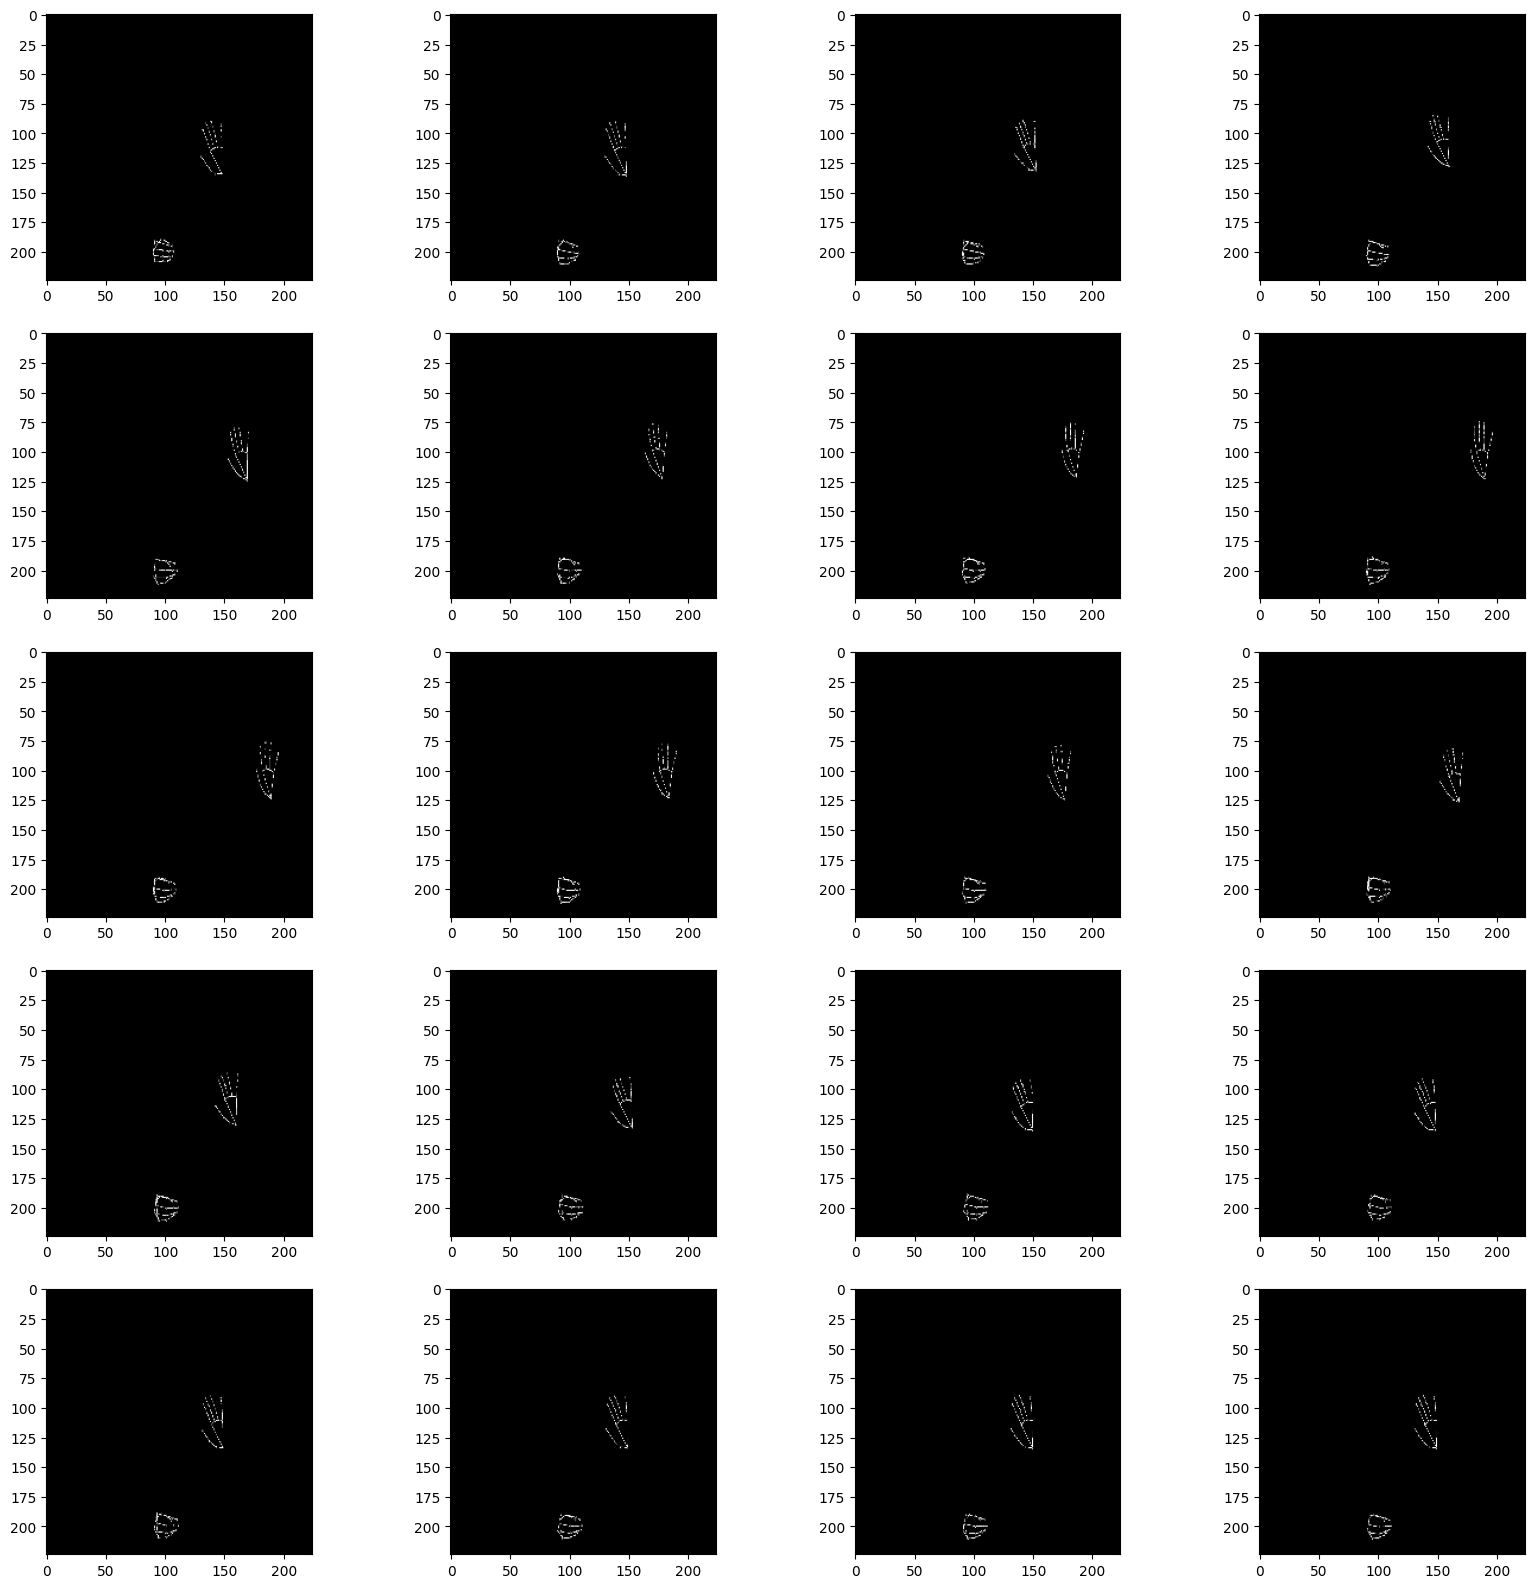

In [23]:
f,ax = plt.subplots(5,4, figsize= (20,20))
for i in range(5):
    for j in range(4):
        ax[i,j].imshow(showFrames[i][j], cmap='gray')

In [24]:
f.savefig("figure.png")

# Test ConvLSTM Model

In [ ]:
prediction = np.argmax(model.predict(frames))+1
prediction

In [ ]:
model.predict(frames)[0][prediction-1]

# Test LRCN Model

In [23]:
modelLRCN = load_model('./models/LRCNhandsOnly')

In [ ]:
model_ev_LRCN = modelLRCN.evaluate(x_test,y_test)

In [ ]:
prediction = np.argmax(modelLRCN.predict(frames))+1
prediction

In [ ]:
modelLRCN.predict(frames)[0][prediction-1]

# Preparation of experimental data

## Gloveless videos sample

In [37]:
glovelessTestPath = pathlib.Path('./pruebas/landmarksVids')
glovelessVids = list(glovelessTestPath.glob('*.avi'))
glovelessVids

[WindowsPath('pruebas/landmarksVids/sign01.avi'),
 WindowsPath('pruebas/landmarksVids/sign02.avi'),
 WindowsPath('pruebas/landmarksVids/sign03.avi'),
 WindowsPath('pruebas/landmarksVids/sign04.avi'),
 WindowsPath('pruebas/landmarksVids/sign05.avi'),
 WindowsPath('pruebas/landmarksVids/sign06.avi'),
 WindowsPath('pruebas/landmarksVids/sign07.avi'),
 WindowsPath('pruebas/landmarksVids/sign08.avi'),
 WindowsPath('pruebas/landmarksVids/sign09.avi'),
 WindowsPath('pruebas/landmarksVids/sign10.avi'),
 WindowsPath('pruebas/landmarksVids/sign11.avi'),
 WindowsPath('pruebas/landmarksVids/sign12.avi'),
 WindowsPath('pruebas/landmarksVids/sign13.avi'),
 WindowsPath('pruebas/landmarksVids/sign14.avi'),
 WindowsPath('pruebas/landmarksVids/sign15.avi'),
 WindowsPath('pruebas/landmarksVids/sign16.avi'),
 WindowsPath('pruebas/landmarksVids/sign17.avi'),
 WindowsPath('pruebas/landmarksVids/sign18.avi'),
 WindowsPath('pruebas/landmarksVids/sign19.avi'),
 WindowsPath('pruebas/landmarksVids/sign20.avi'),


## Colored gloves sample

In [ ]:
gloveTestPath = pathlib.Path('./pruebas/serie_prueba_guantes')
gloveVids = list(gloveTestPath.glob('*.mp4'))
gloveVids

### Preparing the labels

In [38]:
labelsPruebas = np.array(list(range(64)),dtype='int16')

In [ ]:
labelsPruebas

### Preparing gloveless videos array 

In [45]:
x_bare = np.array([resizeVid(frames_extraction(str(p))) for p in glovelessVids],dtype='float16') 

Video url: pruebas\landmarksVids\sign01.avi, video_length:46
Video url: pruebas\landmarksVids\sign02.avi, video_length:54
Video url: pruebas\landmarksVids\sign03.avi, video_length:60
Video url: pruebas\landmarksVids\sign04.avi, video_length:42
Video url: pruebas\landmarksVids\sign05.avi, video_length:52
Video url: pruebas\landmarksVids\sign06.avi, video_length:47
Video url: pruebas\landmarksVids\sign07.avi, video_length:40
Video url: pruebas\landmarksVids\sign08.avi, video_length:58
Video url: pruebas\landmarksVids\sign09.avi, video_length:67
Video url: pruebas\landmarksVids\sign10.avi, video_length:43
Video url: pruebas\landmarksVids\sign11.avi, video_length:46
Video url: pruebas\landmarksVids\sign12.avi, video_length:57
Video url: pruebas\landmarksVids\sign13.avi, video_length:48
Video url: pruebas\landmarksVids\sign14.avi, video_length:50
Video url: pruebas\landmarksVids\sign15.avi, video_length:37
Video url: pruebas\landmarksVids\sign16.avi, video_length:61
Video url: pruebas\landm

In [43]:
x_bare.shape

(64, 20, 224, 224, 1)

## Testing the ConvLSTM model with the gloveless set

In [46]:
model.evaluate(x_bare,labelsPruebas)

2/2 [==============================] - 9s 4s/step - loss: 4.8543 - accuracy: 0.4844


[4.854253768920898, 0.484375]

### Model's predictions

In [ ]:
predictionsBare = np.array([np.argmax(c) for c in model.predict(x_bare)])

In [ ]:
predictionsBare

### Signs that were correctly predicted

In [ ]:
ok_bare = labelsPruebas[predictionsBare == labelsPruebas]

In [ ]:
ok_bare

In [ ]:
x_gloves = np.array([resizeVid(frames_extraction(str(p))) for p in gloveVids],dtype='float16') 

In [ ]:
x_gloves.shape

In [ ]:
model.evaluate(x_gloves,labelsPruebas)

In [48]:
modelLRCN.evaluate(x_bare,labelsPruebas)

2/2 [==============================] - 1s 594ms/step - loss: 5.6703 - accuracy: 0.0781


[5.670297622680664, 0.078125]

In [ ]:
modelLRCN.evaluate(x_gloves,labelsPruebas)